In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os

In [2]:
collection_psgs_file_path = (
    "/home/elionis/IR-Project/data/msmarco_doc/collection_psgs.tsv"
)
dov_qrels_file_path = (
    "/home/elionis/IR-Project/data/msmarco_doc/msmarco-docdev-qrels.tsv"
)
docdev_queries = "/home/elionis/IR-Project/data/msmarco_doc/msmarco-docdev-queries.tsv"
doctrain_queries = (
    "/home/elionis/IR-Project/data/msmarco_doc/msmarco-doctrain-queries.tsv"
)
RUN_MAX_SCORE_FOLDER = "/home/elionis/IR-Project/data/msmarco_doc"
SEGMENT_TO_CUT = 3
CHUNK_SIZE = 1000
TO_SAVE_FILES = True
TO_SAVE_FILES_COLLECTION = False
PRUNNING_CANDIDATE_FILES = False
TOP_K = 200

Get the psgs that you want to exclude

In [3]:
f = open(collection_psgs_file_path, "r")
collection_psgs_file_length = sum(1 for row in f if row.strip())
f.close()

In [4]:
document_segment_pair = []
f = open(collection_psgs_file_path, "r")
for row in tqdm(f, total=collection_psgs_file_length):
    document, segment = row.split("\t")[0].split("@@")
    document_segment_pair.append({"document": document, "segment": int(segment) + 1})
f.close()
df = pd.DataFrame(document_segment_pair)
max_numbers = df.groupby("document")["segment"].max().reset_index()
short = max_numbers[max_numbers["segment"] < SEGMENT_TO_CUT]["document"].tolist()

100%|██████████| 14980547/14980547 [01:34<00:00, 159294.09it/s]


In [8]:
"D149214" in short

False

In [6]:
document_segment_pair = []
output_file_short = collection_psgs_file_path.split(".")[0] + "_short_dataset.tsv"
output_file_long = collection_psgs_file_path.split(".")[0] + "_long_dataset.tsv"
f = open(collection_psgs_file_path, "r")
if TO_SAVE_FILES_COLLECTION:
    shorts_files = []
    long_files = []
    with open(
        output_file_short, "w"
    ) as f_out_short:  # Open file in write mode to start fresh
        with open(
            output_file_long, "w"
        ) as f_out_long:  # Open file in write mode to start fresh
            for row in tqdm(f, total=collection_psgs_file_length):
                document, _ = row.split("\t")[0].split("@@")
                if document in short:
                    shorts_files.append(row if "\n" in row else row + "\n")
                    if len(shorts_files) > CHUNK_SIZE:
                        f_out_long.writelines(shorts_files)
                        shorts_files = []
                        print("writing collection_short_file")
                else:
                    long_files.append(row if "\n" in row else row + "\n")
                    if len(long_files) > CHUNK_SIZE:
                        f_out_long.writelines(long_files)
                        long_files = []
                        print("writing collection_long_file")
f.close()

TOTAL documents: 3213596
TOTAL counts for the 3 first passages with the total percentage that they take
(2107974, 0.490336059666492)
show passages that are up to 66\% of total documnets
           count   cumsum  percentage
segment                             
1        783493   783493    0.243806
2        792249  1575742    0.490336
3        532232  2107974    0.655955
show total remainder documents: 1105622


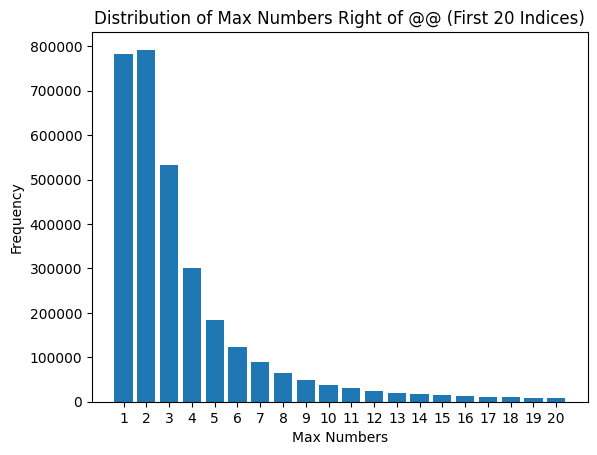

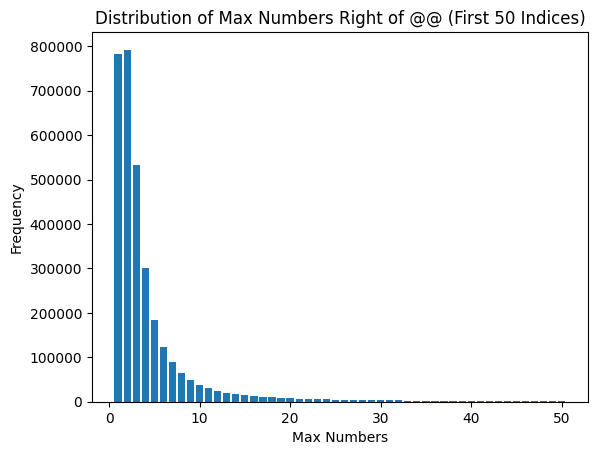

In [7]:
distribution = pd.Series(max_numbers["segment"]).value_counts()
sorted_distribution = distribution.sort_index()
sorted_pd = sorted_distribution.to_frame()

total_number = sorted_pd.sum(0).values[0]
print("TOTAL documents:", total_number)
print("TOTAL counts for the 3 first passages with the total percentage that they take")
x = (
    sorted_pd.filter(items=[1, 2, 3], axis=0).sum(0).values[0],
    sorted_pd.filter(items=[0, 1, 2], axis=0).sum(0).values[0] / total_number,
)
print(x)
sorted_pd["cumsum"] = sorted_pd["count"].cumsum(0)
sorted_pd["percentage"] = sorted_pd["count"].cumsum(0) / total_number
# sorted_pd.percentage>0.65

print(
    "show passages that are up to 66\% of total documnets\n",
    sorted_pd[sorted_pd.percentage < 0.66],
)
# sorted_pd[sorted_pd.percentage>0.66]

print(
    "show total remainder documents:",
    sorted_pd[sorted_pd.percentage > 0.66]["count"].sum(),
)

top_20_distribution = sorted_distribution.head(20)

plt.bar(top_20_distribution.index, top_20_distribution.values)
plt.xlabel("Max Numbers")
plt.ylabel("Frequency")
plt.title("Distribution of Max Numbers Right of @@ (First 20 Indices)")
plt.xticks(top_20_distribution.index)  # Ensure all x-ticks are shown
plt.show()

top_50_distribution = sorted_distribution.head(50)

plt.bar(top_50_distribution.index, top_50_distribution.values)
plt.xlabel("Max Numbers")
plt.ylabel("Frequency")
plt.title("Distribution of Max Numbers Right of @@ (First 50 Indices)")
plt.show()

QRELS split

In [8]:
file_length = sum(1 for row in open(dov_qrels_file_path, "r"))
total_chunks = file_length // CHUNK_SIZE + 1  # Adjust for chunksize
output_file_short = dov_qrels_file_path.split(".")[0] + "_short_dataset.tsv"
output_file_long = dov_qrels_file_path.split(".")[0] + "_long_dataset.tsv"
if TO_SAVE_FILES:
    with open(output_file_short, "w") as f_out_short:
        with open(output_file_long, "w") as f_out_long:
            for chunk in tqdm(
                pd.read_csv(
                    dov_qrels_file_path,
                    sep=" ",
                    header=None,
                    chunksize=CHUNK_SIZE,
                    iterator=True,
                ),
                total=total_chunks,
            ):
                chunk = chunk.rename(columns={0: "queries", 2: "documents"})
                flags = chunk["documents"].isin(short)
                filtered_chunk_short = chunk[flags]
                filtered_chunk_short.to_csv(
                    f_out_short, sep=" ", index=False, header=False
                )
                filtered_chunk_long = chunk[~flags]
                filtered_chunk_long.to_csv(
                    f_out_long, sep=" ", index=False, header=False
                )
    print("SAVED", output_file_short)
    print("SAVED", output_file_long)

100%|██████████| 6/6 [00:07<00:00,  1.29s/it]

SAVED /home/elionis/IR-Project/data/msmarco_doc/msmarco-docdev-qrels_short_dataset.tsv
SAVED /home/elionis/IR-Project/data/msmarco_doc/msmarco-docdev-qrels_long_dataset.tsv


In [9]:
original = pd.read_csv(dov_qrels_file_path, sep=" ", header=None)
qrels_short = pd.read_csv(
    dov_qrels_file_path.split(".")[0] + "_short_dataset.tsv", sep=" ", header=None
)
qrels_long = pd.read_csv(
    dov_qrels_file_path.split(".")[0] + "_long_dataset.tsv", sep=" ", header=None
)
print("Original dov_qrels size", original[0].count())
print("short dov_qrels size", qrels_short[0].count())
print(
    "SHORT DIF:",
    original[0].count() - qrels_short[0].count(),
    "SHORT PER PERCENTAGE",
    qrels_short[0].count() / original[0].count(),
)
print("long dov_qrels size", qrels_long[0].count())
print(
    "LONG DIF:",
    original[0].count() - qrels_long[0].count(),
    "LONG PER PERCENTAGE",
    qrels_long[0].count() / original[0].count(),
)
short_queries = list(set(qrels_short[0].tolist()))
long_queries = list(set(qrels_long[0].tolist()))

Original dov_qrels size 5193
short dov_qrels size 2398
SHORT DIF: 2795 SHORT PER PERCENTAGE 0.46177546697477373
long dov_qrels size 2795
LONG DIF: 2398 LONG PER PERCENTAGE 0.5382245330252262


DOC DEV Queries SPLIT

In [10]:
df_docdev_queries = pd.read_csv(docdev_queries, sep="\t", header=None)
df_docdev_queries = df_docdev_queries.rename(columns={0: "query", 1: "text"})
# df_docdev_queries["query"] = df_docdev_queries["query"].astype(str)
df_docdev_queries_short = df_docdev_queries[
    df_docdev_queries["query"].isin(short_queries)
]

print("df_docdev_queries with short")
print("Before join:", df_docdev_queries["query"].count())
print("AFTER join:", df_docdev_queries_short["query"].count())
print(
    "DIFF:",
    df_docdev_queries["query"].count() - df_docdev_queries_short["query"].count(),
    "PERCENTAGE",
    df_docdev_queries_short["query"].count() / df_docdev_queries["query"].count(),
)


df_docdev_queries_long = df_docdev_queries[
    df_docdev_queries["query"].isin(long_queries)
]
print("df_docdev_queries with short")
print("Before join:", df_docdev_queries["query"].count())
print("AFTER join:", df_docdev_queries_long["query"].count())
print(
    "DIFF:",
    df_docdev_queries["query"].count() - df_docdev_queries_long["query"].count(),
    "PERCENTAGE",
    df_docdev_queries_long["query"].count() / df_docdev_queries["query"].count(),
)

df_docdev_queries with short
Before join: 5193
AFTER join: 2398
DIFF: 2795 PERCENTAGE 0.46177546697477373
df_docdev_queries with short
Before join: 5193
AFTER join: 2795
DIFF: 2398 PERCENTAGE 0.5382245330252262


In [11]:
output_file = docdev_queries.split(".")[0] + "_short_dataset.tsv"
if TO_SAVE_FILES:
    with open(output_file, "w"):
        df_docdev_queries_short.to_csv(output_file, sep="\t", index=False, header=False)
    print("SAVED", output_file)

output_file = docdev_queries.split(".")[0] + "_long_dataset.tsv"
if TO_SAVE_FILES:
    with open(output_file, "w"):
        df_docdev_queries_long.to_csv(output_file, sep="\t", index=False, header=False)
    print("SAVED", output_file)

SAVED /home/elionis/IR-Project/data/msmarco_doc/msmarco-docdev-queries_short_dataset.tsv
SAVED /home/elionis/IR-Project/data/msmarco_doc/msmarco-docdev-queries_long_dataset.tsv


CANDIDATE FILES CHANGE

In [17]:
if PRUNNING_CANDIDATE_FILES:
    for file in os.listdir(RUN_MAX_SCORE_FOLDER):
        if (
            not ("run_max_score" in file and ".trec" in file)
            or "long" in file
            or "short" in file
        ):
            continue
        print("file", file)
        df = pd.read_csv(RUN_MAX_SCORE_FOLDER + "/" + file, header=None, sep=" ")
        df = df.rename(columns={0: "query", 2: "document"})
        df = df.groupby("query").head(TOP_K)
        output_file_keep_TOP_K = (
            RUN_MAX_SCORE_FOLDER
            + "/"
            + file.split(".")[0]
            + "_keep_"
            + str(TOP_K)
            + "."
            + file.split(".")[1]
        )

        if TO_SAVE_FILES:
            with open(output_file_keep_TOP_K, "w"):
                df.to_csv(output_file_keep_TOP_K, sep=" ", index=False, header=False)
            print("SAVED", output_file_keep_TOP_K)

for file in os.listdir(RUN_MAX_SCORE_FOLDER):
    if (
        not (
            "run_max_score" in file
            and ".trec" in file
            and "_keep_" + str(TOP_K) in file
        )
        or "long" in file
        or "short" in file
    ):
        continue

    df = pd.read_csv(RUN_MAX_SCORE_FOLDER + "/" + file, header=None, sep=" ")
    df = df.rename(columns={0: "query", 2: "document"})

    flag_short = df["document"].isin(short)
    short_df = df[flag_short]

    short_df = short_df[short_df["query"].isin(short_queries)]

    print(f"{RUN_MAX_SCORE_FOLDER}/{file} before removing:\t", df["query"].count())
    print(f"{RUN_MAX_SCORE_FOLDER}/{file} after removing:\t", short_df["query"].count())
    print(
        "DIFF:\t",
        df["query"].count() - short_df["query"].count(),
        "\tPERC:\t",
        short_df["query"].count() / df["query"].count(),
    )

    long_df = df[~flag_short]
    long_df = long_df[long_df["query"].isin(long_queries)]

    print(f"{RUN_MAX_SCORE_FOLDER}/{file} before removing:\t", df["query"].count())
    print(f"{RUN_MAX_SCORE_FOLDER}/{file} after removing:\t", long_df["query"].count())
    print(
        "DIFF:\t",
        df["query"].count() - long_df["query"].count(),
        "\tPERC:\t",
        long_df["query"].count() / df["query"].count(),
    )

    output_file_short = (
        RUN_MAX_SCORE_FOLDER
        + "/"
        + file.split(".")[0]
        + "_short_dataset"
        + "."
        + file.split(".")[1]
    )
    output_file_long = (
        RUN_MAX_SCORE_FOLDER
        + "/"
        + file.split(".")[0]
        + "_long_dataset"
        + "."
        + file.split(".")[1]
    )

    if TO_SAVE_FILES:
        with open(output_file_short, "w"):
            short_df.to_csv(output_file_short, sep=" ", index=False, header=False)
        print("SAVED", output_file_short)
        with open(output_file_long, "w"):
            long_df.to_csv(output_file_long, sep=" ", index=False, header=False)
        print("SAVED", output_file_long)

/home/elionis/IR-Project/data/msmarco_doc/run_max_score_3_keep_200.trec before removing:	 1038600
/home/elionis/IR-Project/data/msmarco_doc/run_max_score_3_keep_200.trec after removing:	 181495
DIFF:	 857105 	PERC:	 0.17474966300789524
/home/elionis/IR-Project/data/msmarco_doc/run_max_score_3_keep_200.trec before removing:	 1038600
/home/elionis/IR-Project/data/msmarco_doc/run_max_score_3_keep_200.trec after removing:	 379171
DIFF:	 659429 	PERC:	 0.3650789524359715
SAVED /home/elionis/IR-Project/data/msmarco_doc/run_max_score_3_keep_200_short_dataset.trec
SAVED /home/elionis/IR-Project/data/msmarco_doc/run_max_score_3_keep_200_long_dataset.trec
/home/elionis/IR-Project/data/msmarco_doc/run_max_score_1_keep_200.trec before removing:	 1038600
/home/elionis/IR-Project/data/msmarco_doc/run_max_score_1_keep_200.trec after removing:	 239063
DIFF:	 799537 	PERC:	 0.23017812439822838
/home/elionis/IR-Project/data/msmarco_doc/run_max_score_1_keep_200.trec before removing:	 1038600
/home/elioni

Train triplets Split

In [13]:
train_triplets = "/home/elionis/IR-Project/data/msmarco_doc/train_triplets.tsv"
df = pd.read_csv(train_triplets, sep="\t", header=None)
df = df.rename(columns={0: "queries", 1: "pos_doc", 2: "neg_doc"})
# remove the rows that have the same positive and negative document
df = df[df["pos_doc"] != df["neg_doc"]]
# remove positive documents that are in ids_that_should_be_deleted
flags_pos_doc = df["pos_doc"].isin(short)
short_df = df[flags_pos_doc]
short_df = short_df[short_df["neg_doc"].isin(short)]

print("train_triplets before removing:\t", df["queries"].count())
print("train_triplets after removing:\t", short_df["queries"].count())
print(
    "DIFF:\t",
    df["queries"].count() - short_df["queries"].count(),
    "\tPERC:\t",
    short_df["queries"].count() / df["queries"].count(),
)


# remove positive documents that are in ids_that_should_be_deleted
long_df = df[~flags_pos_doc]
long_df = long_df[~long_df["neg_doc"].isin(short)]

print("train_triplets before removing:\t", df["queries"].count())
print("train_triplets after removing:\t", long_df["queries"].count())
print(
    "DIFF:\t",
    df["queries"].count() - long_df["queries"].count(),
    "\tPERC:\t",
    long_df["queries"].count() / df["queries"].count(),
)

short_queries_train = list(set(short_df["queries"].tolist()))
long_queries_train = list(set(long_df["queries"].tolist()))

train_triplets before removing:	 1757771
train_triplets after removing:	 268259
DIFF:	 1489512 	PERC:	 0.15261316747175827
train_triplets before removing:	 1757771
train_triplets after removing:	 669637
DIFF:	 1088134 	PERC:	 0.3809580428849947


In [14]:
output_file = train_triplets.split(".")[0] + "_short_dataset.tsv"
if TO_SAVE_FILES:
    with open(output_file, "w"):
        short_df.to_csv(output_file, sep="\t", index=False, header=False)
    print("SAVED", output_file)

output_file = train_triplets.split(".")[0] + "_long_dataset.tsv"
if TO_SAVE_FILES:
    with open(output_file, "w"):
        long_df.to_csv(output_file, sep="\t", index=False, header=False)
    print("SAVED", output_file)

SAVED /home/elionis/IR-Project/data/msmarco_doc/train_triplets_short_dataset.tsv
SAVED /home/elionis/IR-Project/data/msmarco_doc/train_triplets_long_dataset.tsv


DOC TRAIN QUERIES SPLIT

In [15]:
df_doctrain_queries = pd.read_csv(doctrain_queries, sep="\t", header=None)
df_doctrain_queries = df_doctrain_queries.rename(columns={0: "query", 1: "text"})

df_doctrain_queries_short = df_doctrain_queries[
    df_doctrain_queries["query"].isin(short_queries_train)
]
print("df_doctrain_queries with short")
print("Before join:", df_doctrain_queries["query"].count())
print("AFTER join:", df_doctrain_queries_short["query"].count())
print(
    "DIFF:",
    df_doctrain_queries["query"].count() - df_doctrain_queries_short["query"].count(),
    "PERCENTAGE",
    df_doctrain_queries_short["query"].count() / df_doctrain_queries["query"].count(),
)

df_doctrain_queries_long = df_doctrain_queries[
    df_doctrain_queries["query"].isin(long_queries_train)
]
print("df_doctrain_queries with long")
print("Before join:", df_doctrain_queries["query"].count())
print("AFTER join:", df_doctrain_queries_long["query"].count())
print(
    "DIFF:",
    df_doctrain_queries["query"].count() - df_doctrain_queries_long["query"].count(),
    "PERCENTAGE",
    df_doctrain_queries_long["query"].count() / df_doctrain_queries["query"].count(),
)

df_doctrain_queries with short
Before join: 367013
AFTER join: 132934
DIFF: 234079 PERCENTAGE 0.3622051534959252
df_doctrain_queries with long
Before join: 367013
AFTER join: 190127
DIFF: 176886 PERCENTAGE 0.5180388705577187


In [16]:
output_file = doctrain_queries.split(".")[0] + "_short_dataset.tsv"
if TO_SAVE_FILES:
    with open(output_file, "w"):
        df_doctrain_queries_short.to_csv(
            output_file, sep="\t", index=False, header=False
        )
    print("SAVED", output_file)

output_file = doctrain_queries.split(".")[0] + "_long_dataset.tsv"
if TO_SAVE_FILES:
    with open(output_file, "w"):
        df_doctrain_queries_long.to_csv(
            output_file, sep="\t", index=False, header=False
        )
    print("SAVED", output_file)

SAVED /home/elionis/IR-Project/data/msmarco_doc/msmarco-doctrain-queries_short_dataset.tsv
SAVED /home/elionis/IR-Project/data/msmarco_doc/msmarco-doctrain-queries_long_dataset.tsv


TEST MAX SCORE WITHOUT PRUNNING

In [20]:
for file in os.listdir(RUN_MAX_SCORE_FOLDER):
    if (
        not ("run_max_score" in file and ".trec" in file)
        or "long" in file
        or "short" in file
        or "_keep_" + str(TOP_K) in file
    ):
        continue

    df = pd.read_csv(RUN_MAX_SCORE_FOLDER + "/" + file, header=None, sep=" ")
    df = df.rename(columns={0: "query", 2: "document"})

    flag_short = df["document"].isin(short)
    short_df = df[flag_short]

    short_df = short_df[short_df["query"].isin(short_queries)]

    print(f"{RUN_MAX_SCORE_FOLDER}/{file} before removing:\t", df["query"].count())
    print(f"{RUN_MAX_SCORE_FOLDER}/{file} after removing:\t", short_df["query"].count())
    print(
        "DIFF:\t",
        df["query"].count() - short_df["query"].count(),
        "\tPERC:\t",
        short_df["query"].count() / df["query"].count(),
    )

    long_df = df[~flag_short]
    long_df = long_df[long_df["query"].isin(long_queries)]

    print(f"{RUN_MAX_SCORE_FOLDER}/{file} before removing:\t", df["query"].count())
    print(f"{RUN_MAX_SCORE_FOLDER}/{file} after removing:\t", long_df["query"].count())
    print(
        "DIFF:\t",
        df["query"].count() - long_df["query"].count(),
        "\tPERC:\t",
        long_df["query"].count() / df["query"].count(),
    )

    output_file_short = (
        RUN_MAX_SCORE_FOLDER
        + "/"
        + file.split(".")[0]
        + "_short_dataset"
        + "."
        + file.split(".")[1]
    )
    output_file_long = (
        RUN_MAX_SCORE_FOLDER
        + "/"
        + file.split(".")[0]
        + "_long_dataset"
        + "."
        + file.split(".")[1]
    )

    if TO_SAVE_FILES:
        with open(output_file_short, "w"):
            short_df.to_csv(output_file_short, sep=" ", index=False, header=False)
        print("SAVED", output_file_short)
        with open(output_file_long, "w"):
            long_df.to_csv(output_file_long, sep=" ", index=False, header=False)
        print("SAVED", output_file_long)

/home/elionis/IR-Project/data/msmarco_doc/run_max_score_4.trec before removing:	 5192643
/home/elionis/IR-Project/data/msmarco_doc/run_max_score_4.trec after removing:	 795484
DIFF:	 4397159 	PERC:	 0.1531944329698768
/home/elionis/IR-Project/data/msmarco_doc/run_max_score_4.trec before removing:	 5192643
/home/elionis/IR-Project/data/msmarco_doc/run_max_score_4.trec after removing:	 1996443
DIFF:	 3196200 	PERC:	 0.3844753047725407
SAVED /home/elionis/IR-Project/data/msmarco_doc/run_max_score_4_short_dataset.trec
SAVED /home/elionis/IR-Project/data/msmarco_doc/run_max_score_4_long_dataset.trec
/home/elionis/IR-Project/data/msmarco_doc/run_max_score_5.trec before removing:	 5192779
/home/elionis/IR-Project/data/msmarco_doc/run_max_score_5.trec after removing:	 754421
DIFF:	 4438358 	PERC:	 0.1452827089309982
/home/elionis/IR-Project/data/msmarco_doc/run_max_score_5.trec before removing:	 5192779
/home/elionis/IR-Project/data/msmarco_doc/run_max_score_5.trec after removing:	 2042124
DIF